In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from __future__ import annotations
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [ ]:
import RaTag.cuts as cuts # type: ignore
import RaTag.dataIO as dataIO # type: ignore
import RaTag.config as config # type: ignore
import RaTag.analysis as analysis # type: ignore
import RaTag.transport as transport # type: ignore
import RaTag.plotting as plotting # type: ignore
from RaTag.runs import Run # type: ignore
# import RaTag.measurements as meas

# Test run module

In [107]:
base_dir = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec')
meas_path = base_dir / 'FieldScan_5GSsec_Anode2000V_Gate100V'
wfm_paths = sorted(meas_path.glob('*.wfm'))

In [7]:
EL_gap = 0.8 # cm
drift_length = 1.4 # cm
gas_density=4.91e19 # cm^-3
bs_t_window=(-1.5e-5, -1.0e-5)  # 15-10 us before trigger
t_s1 = -3.74e-6  # s1 time (s)

In [103]:
run5 = Run(
    root_directory = base_dir,
    run_id = "RUN5",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    bs_window = (-1.5e-5, -1.2e-5), # s
    width_s2 = 5.6e-6                # s
)

# Test waveforms module

In [8]:
wf = dataIO.load_wfm(str(wfm_paths[0]))

<Axes: title={'center': 'RUN5_26052025_Gate50_Anode1950_P7_10000Wfm.wfm'}, xlabel='Time (µs)', ylabel='Signal (V)'>

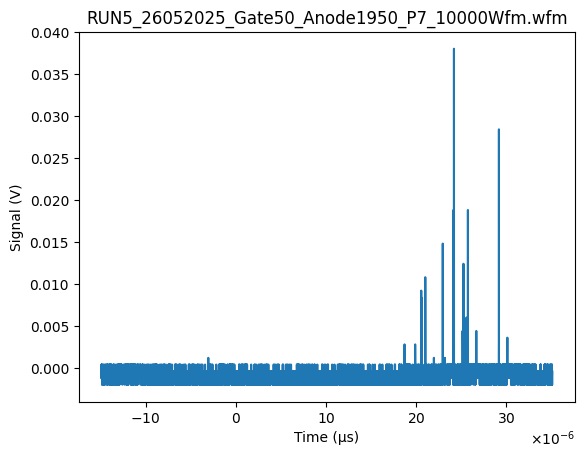

In [72]:
wf.plot()

# Test measurement module

In [108]:
set100 = meas.SetPmt.from_directory(meas_path)
set100.filenames[:3]
set100.metadata['anode'], set100.metadata['gate'], set100.metadata.get('gate')

(2000, 100, 100)

In [109]:
set100 = meas.set_fields(set100, drift_length=drift_length, EL_gap=EL_gap, gas_density=4.91e19)
set100.drift_field, set100.EL_field, set100.red_drift_field

(71.42857142857143, 2375.0, 0.14547570555717196)

In [110]:
set100 = meas.set_transport_properties(set100, drift_length=1.4, transport=None)
set100.time_drift

np.float64(1.5165741857558416e-05)

In [111]:
set100 = meas.estimate_s1_from_batches(set100, height_S1=0.001, batch_size=50)
set100.metadata['t_s1'], set100.metadata['t_s1_std']

(-6.7484474999999996e-06, 5.064997585907001e-06)

## Test cuts

In [ ]:
base_cut = cuts.make_time_amplitude_cut(t_start=bs_t_window[0],
                                        t_end = bs_t_window[1], threshold=0.02)
drift_cut = cuts.make_time_amplitude_cut(t_start=set100.metadata["t_s1"] + 1e-6,
                                     t_end=set100.metadata["t_s1"] + set100.time_drift - 1e-6,
                                     threshold=0.02)
post_cut = cuts.make_time_amplitude_cut(t_start=set100.metadata["t_s1"] + set100.time_drift + width_s2 + 1e-6,
                                   t_end=None, threshold=0.02)
base_cut(wf), drift_cut(wf), post_cut(wf)

((True,
  array([-1.49000e-05, -1.48998e-05, -1.48996e-05, ..., -1.00006e-05,
         -1.00004e-05, -1.00002e-05]),
  array([-0.0012, -0.0012, -0.0012, ..., -0.0012, -0.0012, -0.0012])),
 (True,
  array([-4.65140e-06, -4.65120e-06, -4.65100e-06, ...,  1.33936e-05,
          1.33938e-05,  1.33940e-05]),
  array([-0.0012, -0.0012, -0.0012, ..., -0.0012, -0.0012, -0.0012])),
 (True,
  array([3.13942e-05, 3.13944e-05, 3.13946e-05, ..., 3.50994e-05,
         3.50996e-05, 3.50998e-05]),
  array([-0.0012, -0.0012, -0.0012, ..., -0.0012, -0.0012, -0.0012])))

In [ ]:
# baseline_log = meas.apply_cut(set100, base_cut, "baseline", "Clean baseline")
# drift_log    = meas.apply_cut(set100, drift_cut, "drift", "Clean drift")
# post_log     = meas.apply_cut(set100, post_cut, "post_s2", "No noise after S2")

# all_log = meas.combine_logs([baseline_log, drift_log, post_log])

In [ ]:
# Filter the set to only clean waveforms
base_set = meas.filter_set(set100, baseline_log)
drift_set = meas.filter_set(set100, drift_log)
post_set = meas.filter_set(set100, post_log)
clean_set = meas.filter_set(set100, all_log)

In [35]:
len(clean_set), len(drift_set.filenames), len(post_set), len(post_set), len(base_set)

(2105, 2123, 10000, 10000, 9815)

In [ ]:
cut_list = [
    ("baseline", cuts.make_baseline_cut(bs_t_window), "Stable baseline"),
    ("drift_region", meas.drift_region_cut(set100, t_tol=1e-6), "Clean drift region"),
    ("post_s2", meas.post_s2_cut(set100, width_s2=1e-5), "No noise after S2"),
]

logs = [meas.apply_cut(set100, fn, name, reason) for name, fn, reason in cut_list]
clean_set = meas.filter_set(set100, logs)

In [ ]:
set_process = meas.pipe(
    set100,
    lambda s: meas.set_fields(s, drift_length, EL_gap, gas_density),
    lambda s: meas.set_transport_properties(s, drift_length, transport),
    meas.estimate_s1_from_batches,
    # lambda s: meas.evaluate_cuts(s, bs_t_window),
    # lambda s, l: meas.filter_set(s, l),
)


In [241]:
drift_log

RejectionLog(cut_name='drift', cut_fn=<function make_time_amplitude_cut.<locals>.cut at 0x1108cf670>, passed=[0, 5, 6, 15, 20, 26, 29, 38, 43, 44, 56, 60, 69, 75, 77, 84, 87, 94, 96, 101, 107, 108, 112, 123, 124, 131, 132, 144, 145, 151, 152, 153, 157, 162, 163, 165, 166, 171, 179, 180, 183, 187, 189, 191, 192, 197, 203, 212, 219, 222, 231, 235, 243, 254, 256, 260, 263, 269, 273, 276, 277, 290, 304, 307, 309, 310, 316, 321, 332, 333, 335, 337, 344, 345, 348, 350, 354, 357, 358, 360, 361, 366, 368, 369, 376, 381, 388, 393, 396, 399, 404, 405, 408, 409, 410, 412, 414, 415, 417, 420, 425, 443, 451, 452, 459, 466, 468, 469, 478, 479, 487, 504, 507, 514, 515, 519, 524, 539, 543, 546, 549, 553, 558, 560, 565, 567, 568, 570, 583, 586, 587, 590, 598, 600, 602, 610, 620, 625, 626, 637, 643, 644, 648, 649, 650, 658, 663, 672, 676, 687, 692, 701, 710, 716, 720, 725, 735, 736, 745, 760, 767, 772, 775, 777, 794, 798, 802, 806, 810, 815, 820, 821, 827, 829, 838, 841, 852, 856, 860, 863, 873, 884, 88

In [102]:
t1 = [1.5e4, 1.1e4, 1.0e4, 0.8e4, 0.75e4, 0.65e4, 0.55e4]
t2 = [3.5e4, 1.8e4, 1.6e4, 1.4e4, 1.3e4, 1.1e4, 1.05e4]
np.mean(t2[1:] - np.array(t1[1:])) / 1e3

np.float64(5.666666666666667)

## Simple smooth + threshold cut

In [153]:
tol_s21 = 2.7e-6
ts21 = set100.metadata["t_s1"] + set100.time_drift + tol_s21
ts22 = ts21 + run5.width_s2
smooth_cut = cuts.make_smoothed_vertical_cut(vmin = 4e-4, t_start=ts21, t_end=ts22)
ts21, ts22

(np.float64(1.1117294357558416e-05), np.float64(1.6717294357558415e-05))

In [147]:
s2_mask = (wf.t >= ts21) & (wf.t <= ts22)
V_s2 = wf.v[s2_mask]
V_smooth = cuts.moving_average(V_s2, window_size = 9)
ok = V_smooth >= 4e-4
len(ok), len(V_smooth), len(wf.t[s2_mask])

(28000, 28000, 28000)

In [150]:
smooth_cut(wf)

(np.True_,
 array([[1.11174e-05, 1.11176e-05, 1.11178e-05, ..., 1.67168e-05,
         1.67170e-05, 1.67172e-05]]),
 array([[-0.00048889, -0.00062222, -0.00075556, ..., -0.00093333,
         -0.0008    , -0.00066667]]))

In [175]:
smooth_log = meas.apply_cut(set100, smooth_cut, "smooth", "Smooth S2 region")
set100_smooth = meas.filter_set(set100, smooth_log)

SetPmt(source_dir=PosixPath('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V'), filenames=['RUN5_26052025_Gate100_Anode2000_P6_3083Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_2052Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_3565Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_3234Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_2703Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_739Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_6179Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_5971Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_6628Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_3183Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_639Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_6079Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_6728Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_5871Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_168Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_2152Wfm.wfm', 'RUN5_26052025_Gate100_Anode2000_P6_3465Wfm.

# Test plotting module

In [ ]:
set100.metadata['t_s1']

-5.651570588235294e-06

In [ ]:
set100.time_drift

np.float64(20.04565320192623)

In [ ]:
set100.source_dir / set100.filenames[42]

PosixPath('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V/RUN5_26052025_Gate50_Anode1950_P7_9411Wfm.wfm')

<Axes: title={'center': 'RUN5_26052025_Gate100_Anode2000_P6_6104Wfm.wfm'}, xlabel='Time (µs)', ylabel='Signal (V)'>

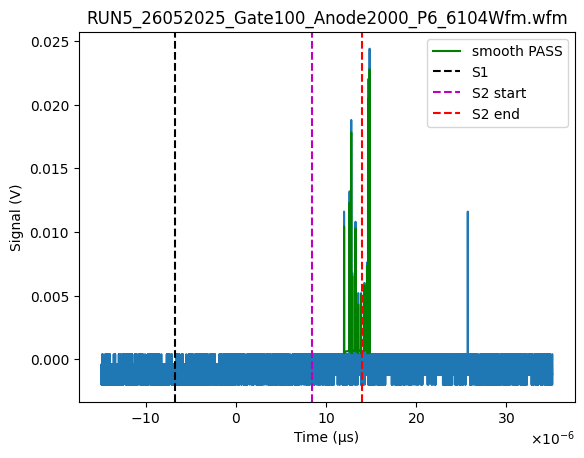

In [156]:
wf = dataIO.load_wfm(set100.source_dir / set100.filenames[42])
plotting.plot_cut_results(wf, set100, [smooth_log], width_s2=run5.width_s2)

<Axes: title={'center': 'RUN5_26052025_Gate50_Anode1950_P7_9411Wfm.wfm'}, xlabel='Time (µs)', ylabel='Signal (V)'>

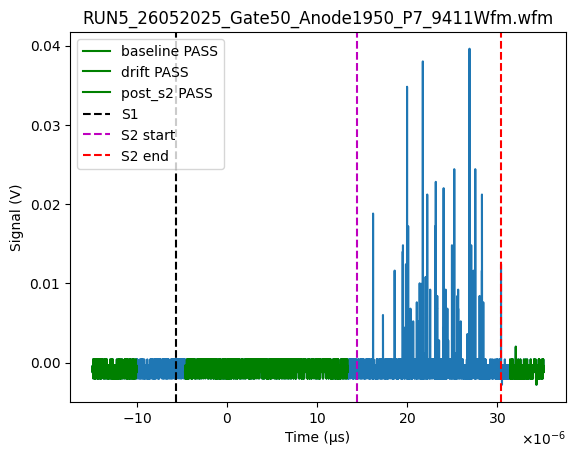

In [ ]:
wf = dataIO.load_wfm(set100.source_dir / set100.filenames[42])
plotting.plot_cut_results(wf, set100, [baseline_log, drift_log, post_log], width_s2=16e-6)

In [ ]:
%matplotlib inline
# fig, ax = plt.subplots()
plotting.scroll_waveforms(set100, [baseline_log, drift_log, post_log], width_s2=16e-6);

IntSlider(value=0, max=9999)

Output()

In [184]:
all_log

RejectionLog(cut_name='all_cuts', passed=[2, 5, 9, 10, 17, 18, 20, 21, 24, 27, 29, 38, 50, 51, 54, 59, 60, 72, 74, 75, 78, 82, 84, 88, 91, 92, 93, 96, 108, 109, 110, 111, 112, 113, 114, 115, 121, 122, 123, 124, 127, 129, 136, 143, 144, 146, 150, 156, 157, 160, 161, 164, 166, 168, 182, 186, 193, 199, 202, 203, 206, 210, 214, 217, 218, 220, 221, 229, 230, 233, 234, 235, 249, 252, 256, 258, 259, 260, 264, 269, 271, 278, 279, 284, 287, 291, 293, 296, 306, 309, 311, 314, 315, 322, 338, 341, 345, 350, 353, 355, 357, 367, 368, 369, 371, 372, 377, 379, 380, 399, 400, 402, 408, 411, 413, 418, 424, 426, 428, 429, 430, 431, 435, 437, 439, 442, 445, 446, 447, 450, 451, 455, 456, 457, 460, 464, 466, 467, 468, 480, 482, 487, 498, 499, 502, 505, 506, 515, 516, 518, 524, 525, 526, 533, 537, 538, 545, 549, 552, 553, 557, 559, 562, 572, 578, 581, 582, 584, 590, 596, 602, 606, 608, 618, 619, 623, 627, 628, 631, 636, 637, 638, 641, 643, 645, 646, 654, 655, 658, 659, 661, 668, 672, 677, 678, 682, 687, 688,

In [ ]:
%matplotlib inline
# fig, ax = plt.subplots()
plotting.scroll_waveforms(clean_set, [baseline_log, drift_log, post_log], width_s2=8e-6)

IntSlider(value=0, max=2104)

Output()

Waveform 1/10000


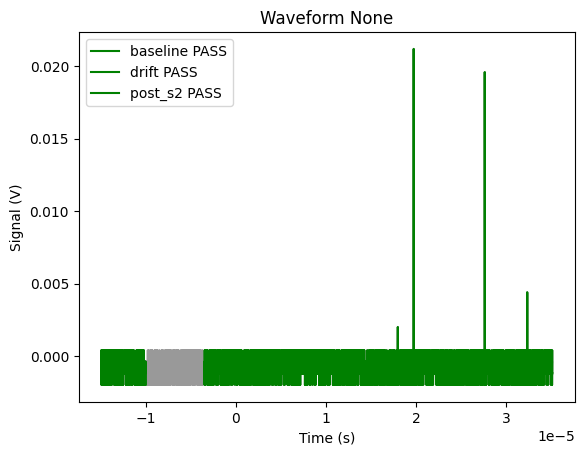

Waveform 2/10000


<Figure size 640x480 with 0 Axes>

Waveform 3/10000


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
# %matplotlib widget
fig, ax = plt.subplots()
plotting.slideshow(set100, [baseline_log, drift_log, post_log], width_s2=8e-6, delay=1.0, ax=ax)

# Pipeline use example

In [ ]:
# build set, compute fields, transport props (transformers)
set0 = SetPmt.from_directory(path)            # your pure constructor that only parses filenames + voltages
set0 = set_fields(set0, drift_length=30.0, EL_gap=5.0, gas_density=...)  # dataclasses.replace under the hood
set0 = set_transport_properties(set0, drift_length, transport)          # adds speed_drift, time_drift

# estimate S1 via batch averaging and add to metadata
set0 = estimate_s1_from_batches(set0, batch_size=20)

# create cut specs (explicit!)
base_spec = make_time_amplitude_cut(*set0.metadata["baseline_window"], threshold=0.02)
drift_spec = make_time_amplitude_cut(t_start=set0.metadata["t_s1"] + 1e-6,
                                     t_end=set0.metadata["t_s1"] + set0.time_drift - 1e-6,
                                     threshold=0.02)
post_spec = make_time_amplitude_cut(t_start=set0.metadata["t_s1"] + set0.time_drift + width_s2 + 1e-6,
                                   t_end=None, threshold=0.02)

# evaluate cuts (explicit, no hidden list)
logs = evaluate_cuts(set0, [base_spec, drift_spec, post_spec])

# Combined log + clean set
all_log = combine_logs(logs)
clean_set = filter_set(set0, all_log)

# integrate S2 on clean_set (e.g. use integrator that reads waveforms lazily)
integration_result = integrate_s2_all(clean_set, s2_window=(...))

# plot a waveform (use lazy loader)
wf = load_waveform(set0.source_dir / set0.filenames[42])
plot_cut_results(wf, set0, logs, wf_index=42, width_s2=1e-5, ax=ax)
